## Exploratory Data Analysis

In [2]:
%pip install seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Load the packages 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [4]:
train = pd.read_csv(
    r"C:\Users\preci\OneDrive\Documents\GitHub\car-insurance-premium-predictor\data\car_insurance_premiums_zar.csv")
test = pd.read_csv(
    r"C:\Users\preci\OneDrive\Documents\GitHub\car-insurance-premium-predictor\data\car_insurance_test_set_zar.csv")
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,Customer_ID,Age,Gender,Region,Employment_Status,Education_Level,Years_Driving,Car_Make,Car_Model,Manufacture_Year,Annual_Mileage,Number_of_Accidents,Number_of_Claims,Car_Value,Premium_Amount,Marital_Status,Has_AntiTheft_Device,Policy_Term,Credit_Score,Vehicle_Usage
0,1,56,Female,Rural,Retired,Master's Degree,22,Volkswagen,Golf,2000,18319,3,0,1600866,50112,Single,1,12,384,Commute
1,2,69,Female,Urban,Employed,Master's Degree,28,BMW,X5,2003,27863,5,1,1737234,40194,Single,0,12,419,Business
2,3,46,Male,Rural,Self-Employed,Bachelor's Degree,0,Chevrolet,Equinox,2006,14834,1,6,315990,57348,Single,1,12,626,Pleasure
3,4,32,Male,Suburban,Self-Employed,Associate Degree,14,Kia,Forte,2021,24495,3,5,1098846,83502,Widowed,1,6,582,Business
4,5,60,Male,Rural,Employed,Doctorate,14,Volkswagen,Passat,2004,24366,1,6,1209096,14040,Single,1,6,590,Pleasure


(10000, 20)

'Test'

,Customer_ID,Age,Gender,Region,Employment_Status,Education_Level,Years_Driving,Car_Make,Car_Model,Manufacture_Year,Annual_Mileage,Number_of_Accidents,Number_of_Claims,Car_Value,Premium_Amount,Marital_Status,Has_AntiTheft_Device,Policy_Term,Credit_Score,Vehicle_Usage
0,1,38,Female,Suburban,Employed,Bachelor's Degree,20,Hyundai,Santa Fe,1995,25244,2,8,187110,73638,Married,0,12,544,Commute
1,2,32,Female,Suburban,Retired,Bachelor's Degree,60,Kia,Soul,2012,25410,2,4,628632,56070,Single,1,6,811,Pleasure
2,3,27,Female,Rural,Self-Employed,Doctorate,18,Honda,Accord,2014,21579,3,8,915660,76158,Married,1,12,835,Commute
3,4,63,Male,Urban,Employed,Associate Degree,54,Nissan,Rogue,2022,9437,3,5,934020,59724,Divorced,0,12,383,Pleasure
4,5,34,Male,Suburban,Self-Employed,Associate Degree,30,Toyota,Corolla,1996,20697,0,6,378990,12636,Single,0,12,349,Commute


(2000, 20)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Customer_ID           10000 non-null  int64 
 1   Age                   10000 non-null  int64 
 2   Gender                10000 non-null  object
 3   Region                10000 non-null  object
 4   Employment_Status     10000 non-null  object
 5   Education_Level       10000 non-null  object
 6   Years_Driving         10000 non-null  int64 
 7   Car_Make              10000 non-null  object
 8   Car_Model             10000 non-null  object
 9   Manufacture_Year      10000 non-null  int64 
 10  Annual_Mileage        10000 non-null  int64 
 11  Number_of_Accidents   10000 non-null  int64 
 12  Number_of_Claims      10000 non-null  int64 
 13  Car_Value             10000 non-null  int64 
 14  Premium_Amount        10000 non-null  int64 
 15  Marital_Status        10000 non-null 

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Customer_ID           2000 non-null   int64 
 1   Age                   2000 non-null   int64 
 2   Gender                2000 non-null   object
 3   Region                2000 non-null   object
 4   Employment_Status     2000 non-null   object
 5   Education_Level       2000 non-null   object
 6   Years_Driving         2000 non-null   int64 
 7   Car_Make              2000 non-null   object
 8   Car_Model             2000 non-null   object
 9   Manufacture_Year      2000 non-null   int64 
 10  Annual_Mileage        2000 non-null   int64 
 11  Number_of_Accidents   2000 non-null   int64 
 12  Number_of_Claims      2000 non-null   int64 
 13  Car_Value             2000 non-null   int64 
 14  Premium_Amount        2000 non-null   int64 
 15  Marital_Status        2000 non-null   

In [ ]:
#Check for duplicates in the train set
train_duplicates = train[train.duplicated()]
print(train_duplicates)

Empty DataFrame
Columns: [Customer_ID, Age, Gender, Region, Employment_Status, Education_Level, Years_Driving, Car_Make, Car_Model, Manufacture_Year, Annual_Mileage, Number_of_Accidents, Number_of_Claims, Car_Value, Premium_Amount, Marital_Status, Has_AntiTheft_Device, Policy_Term, Credit_Score, Vehicle_Usage]
Index: []


In [11]:
#Check for duplicates in the test set
test_duplicates = test[test.duplicated()]
print(test_duplicates)

Empty DataFrame
Columns: [Customer_ID, Age, Gender, Region, Employment_Status, Education_Level, Years_Driving, Car_Make, Car_Model, Manufacture_Year, Annual_Mileage, Number_of_Accidents, Number_of_Claims, Car_Value, Premium_Amount, Marital_Status, Has_AntiTheft_Device, Policy_Term, Credit_Score, Vehicle_Usage]
Index: []


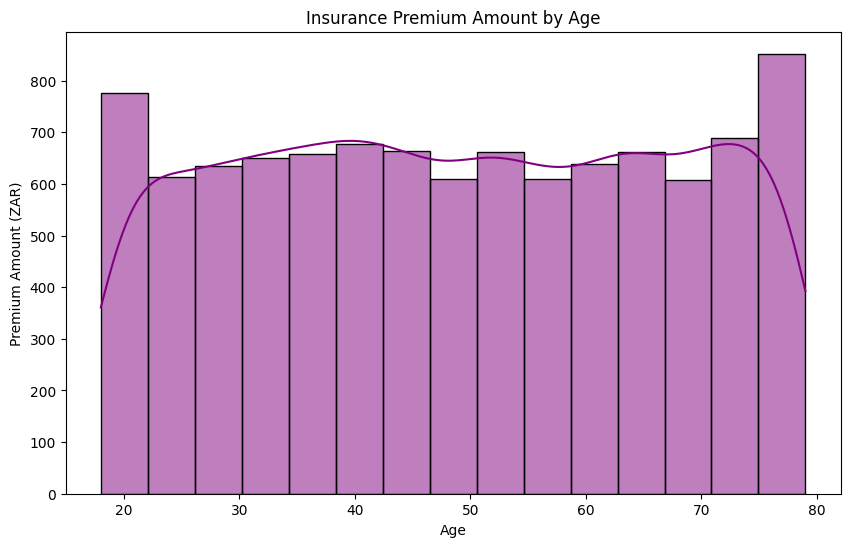

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'], kde=True, bins=15, color="purple")
plt.xlabel("Age")
plt.ylabel("Premium Amount (ZAR)")
plt.title("Insurance Premium Amount by Age")
plt.show()

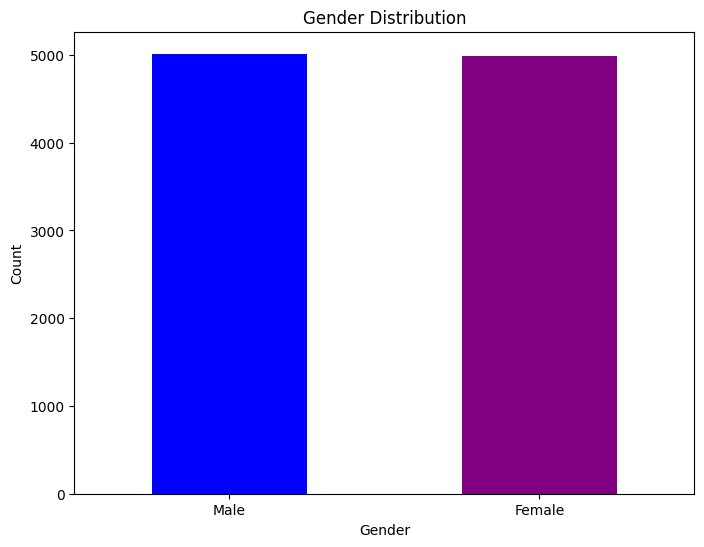

In [15]:
gender_counts = train["Gender"].value_counts()

plt.figure(figsize=(8, 6))
gender_counts.plot(kind="bar", color=["blue", "purple"])
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

C:\Users\preci\AppData\Local\Temp\ipykernel_3264\3302954663.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Region", data=train, palette="muted")


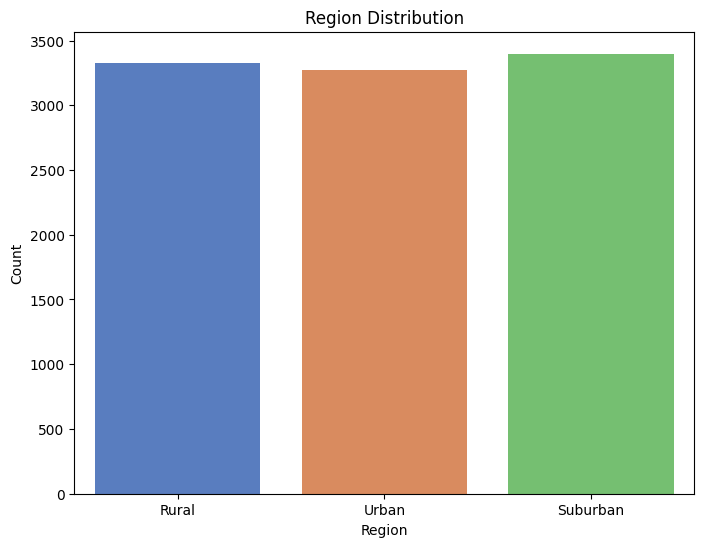

In [23]:
region_counts = train["Region"].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(x="Region", data=train, palette="muted")
plt.title("Region Distribution")
plt.xlabel("Region")
plt.ylabel("Count")
plt.show()

C:\Users\preci\AppData\Local\Temp\ipykernel_3264\4157019734.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Employment_Status", data=train, palette="bright")


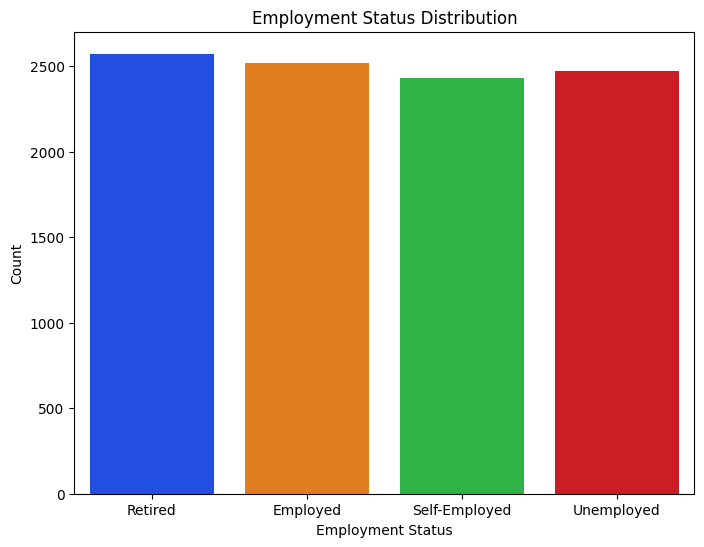

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(x="Employment_Status", data=train, palette="bright")
plt.title("Employment Status Distribution")
plt.xlabel("Employment Status")
plt.ylabel("Count")
plt.show()

C:\Users\preci\AppData\Local\Temp\ipykernel_3264\1703006480.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Education_Level", data=train, palette="dark")


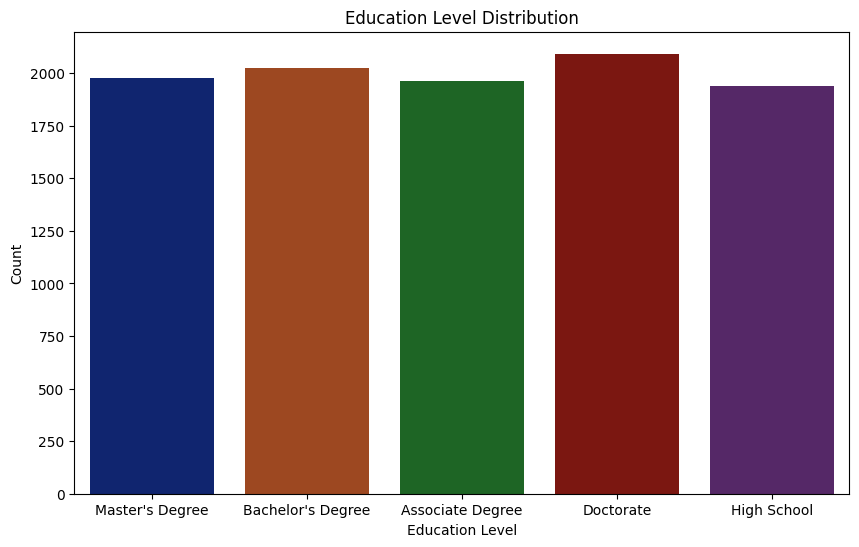

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x="Education_Level", data=train, palette="dark")
plt.title("Education Level Distribution")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.show()

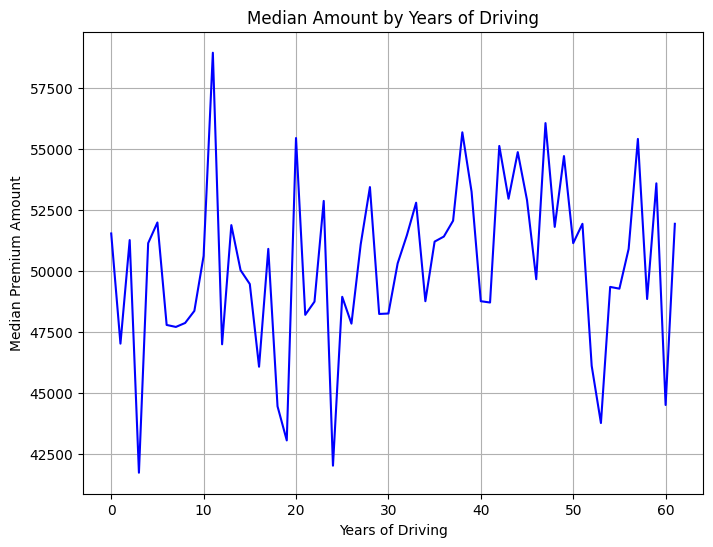

In [32]:
median_years_premiums = train.groupby("Years_Driving")["Premium_Amount"].median().reset_index()
plt.figure(figsize=(8, 6))
sns.lineplot(x="Years_Driving", y="Premium_Amount", data=median_years_premiums, color="b")
plt.xlabel("Years of Driving")
plt.ylabel("Median Premium Amount")
plt.title("Median Amount by Years of Driving")
plt.grid(True)
plt.show()

C:\Users\preci\AppData\Local\Temp\ipykernel_3264\1346522857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Vehicle_Usage", data=train, palette="bright")


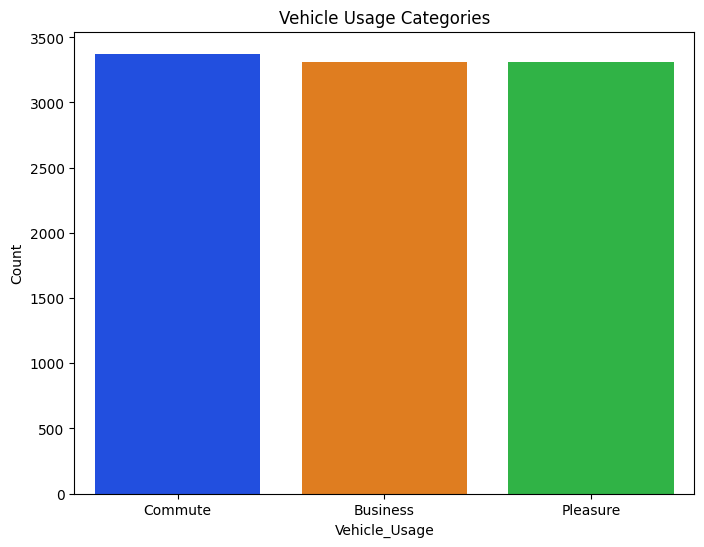

In [31]:
plt.figure(figsize=(8,6))
sns.countplot(x="Vehicle_Usage", data=train, palette="bright")
plt.title("Vehicle Usage Categories")
plt.xlabel("Vehicle_Usage")
plt.ylabel("Count")
plt.show()

C:\Users\preci\AppData\Local\Temp\ipykernel_3264\3874837818.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y="Car_Model", x="Premium_Amount", data = top_10_models, palette="bright")


Text(0.5, 1.0, 'Median Insurane Premium by Car Model')

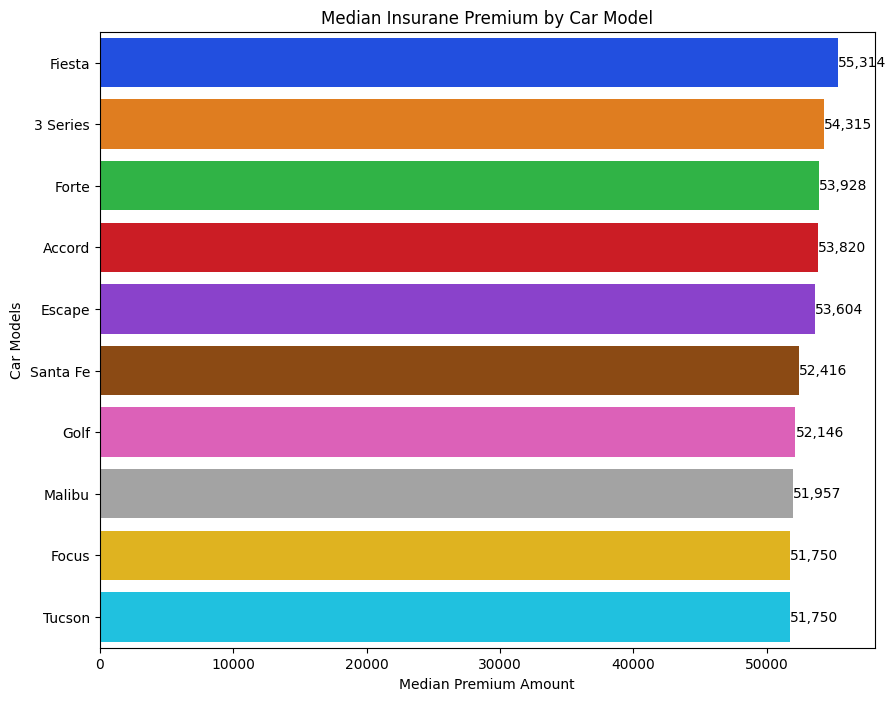

In [38]:
median_model_premiums = train.groupby(
    "Car_Model")["Premium_Amount"].median().reset_index()
top_10_models = median_model_premiums.sort_values(by="Premium_Amount", ascending=False).head(10)
plt.figure(figsize=(10, 8))
ax = sns.barplot(y="Car_Model", x="Premium_Amount", data = top_10_models, palette="bright")

#Add value labels
for index, value in enumerate(top_10_models["Premium_Amount"]):
    plt.text(value, index, f'{value:,.0f}', va="center", fontsize=10)
plt.ylabel("Car Models")
plt.xlabel("Median Premium Amount")
plt.title("Median Insurane Premium by Car Model")

In [36]:
train['Car_Model'].unique()

array(['Golf', 'X5', 'Equinox', 'Forte', 'Passat', 'Sportage', 'Rogue',
       '3 Series', 'Jetta', 'Santa Fe', 'Escape', 'Focus', 'Corolla',
       'Accord', 'E-Class', 'Impala', 'Altima', 'Elantra', 'CR-V',
       'C-Class', 'Fiesta', 'Malibu', 'Sentra', '5 Series', 'GLC',
       'Tucson', 'Camry', 'Civic', 'RAV4', 'Soul'], dtype=object)